In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from math import sqrt, floor
from random import randint

%matplotlib inline
sns.set(style="ticks")

## CP multiplier

In [2]:
# from: https://pokemongo.gamepress.gg/cp-multiplier
df_cpm = pd.read_csv("cpm.csv")
df_cpm.head(2)

level       cpm
0    1.0  0.094000
1    1.5  0.135137

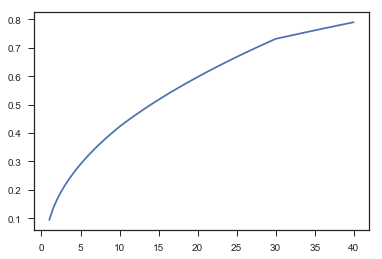

In [3]:
plt.plot(df_cpm["level"], df_cpm["cpm"])

In [4]:
df_cpm = df_cpm.set_index("level")

In [5]:
df_cpm.head(3)

cpm
level          
1.0    0.094000
1.5    0.135137
2.0    0.166398

In [6]:
def cpm(level):
    return float(df_cpm.loc[level])

## Calculate CP

Warning:
- different sources give different base values
- max calculated CP is way below max CP found (eg: Pidgey CP 444, where the model gives CP 331/388)

In [7]:
# from: https://www.reddit.com/r/TheSilphRoad/comments/4t7r4d/exact_pokemon_cp_formula/
# and: https://pokemongo.gamepress.gg/pokemon-stats-advanced
# base values: https://gist.github.com/anonymous/540700108cf0f051e11f70273e9e2590
def compute_CP(level, iv_att=-1, iv_def=-1, iv_sta=-1):
    base_stamina = 80
    base_attack =  94
    base_defense = 90
    
    total_cp_multiplier = cpm(level)

    if iv_sta == -1:
        iv_sta = randint(0,15)
    if iv_def == -1:
        iv_def = randint(0,15)
    if iv_att == -1:
        iv_att = randint(0,15)
        
    stamina = (base_stamina + iv_sta) * total_cp_multiplier
    attack =  (base_attack + iv_att) * total_cp_multiplier
    defense = (base_defense + iv_def) * total_cp_multiplier
    
    cp = attack * sqrt(defense) * sqrt(stamina)  / 10
    
    return max(10, int(cp))

In [8]:
# Max possible:
compute_CP(20, iv_att=15, iv_def=15, iv_sta=15)

388

In [9]:
def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

In [10]:
cp_all = []
n_random_mon = 10000
for level in my_range(1, 20, step=0.5):
    for i in range(n_random_mon):
        cp_all.append(compute_CP(level))

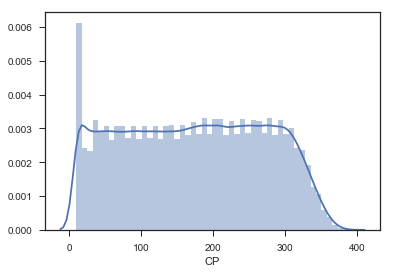

In [11]:
sns.distplot(cp_all, axlabel="CP")

## CP threshold to keep or transfer

In [12]:
n_evolutions = 75
required_candies = 12
n_candies = n_evolutions * (required_candies - 1) # an evolution brings a candy, no time to transfer
print("To make {} evolutions you need {} candies.".format(n_evolutions, n_candies))

To make 75 evolutions you need 825 candies.


In [19]:
min_cp = 10
max_cp = 310 # arbitrary value based on looking to the previous graph

In [20]:
keep = 1
transfer = 1
print('With ananas => keep {} ({} candies), transfer {} ({} candies).'.format(keep,
                                                                              keep*6,
                                                                              transfer,
                                                                              transfer*6+transfer))
ratio = 1 - transfer / (keep+transfer)
print("Homogeneous distribution of cps between {} and {} => keep below cp {} else transfer.".format(min_cp, 
                                                                                                 max_cp, 
                                                                                                 round((min_cp+max_cp)*ratio)))

With ananas => keep 1 (6 candies), transfer 1 (7 candies).
Homogeneous distribution of cps between 10 and 310 => keep below cp 160 else transfer.


In [22]:
keep = 1
transfer = 3
print('Without ananas => keep {} ({} candies), transfer {} ({} candies).'.format(keep,
                                                                                keep*3,
                                                                                transfer,
                                                                                transfer*3+transfer))
ratio = 1 - transfer / (keep+transfer)
print("Homogeneous distribution of cps between {} and {} => keep below cp {} else transfer.".format(min_cp, 
                                                                                                 max_cp, 
                                                                                                 round((min_cp+max_cp)*ratio)))
ratio = 1 - ratio
print("Homogeneous distribution of cps between {} and {} => keep above cp {} else transfer.".format(min_cp, 
                                                                                                 max_cp, 
                                                                                                 round((min_cp+max_cp)*ratio)))

Without ananas => keep 1 (3 candies), transfer 3 (12 candies).
Homogeneous distribution of cps between 10 and 310 => keep below cp 80 else transfer.
Homogeneous distribution of cps between 10 and 310 => keep above cp 240 else transfer.


## CP distribution per level

In [16]:
df = pd.DataFrame()
all_values = []
for i in my_range(1, 20, 0.5):
    cps = [compute_CP(i) for a in range(10000)]
    all_values = all_values + cps
    df[str(i)] = cps
df.head(3)

1  1.5  2.0  2.5  3.0  3.5  4.0  4.5  5.0  5.5  ...   15.5  16.0  16.5  \
0  10   16   26   38   48   52   60   71   82   92  ...    245   283   265   
1  10   16   25   36   44   56   59   71   83   94  ...    274   300   300   
2  10   18   26   34   44   54   65   76   77   89  ...    272   266   289   

   17.0  17.5  18.0  18.5  19.0  19.5  20.0  
0   300   278   261   317   347   308   311  
1   285   295   279   292   343   363   314  
2   308   304   341   302   310   330   335  

[3 rows x 39 columns]

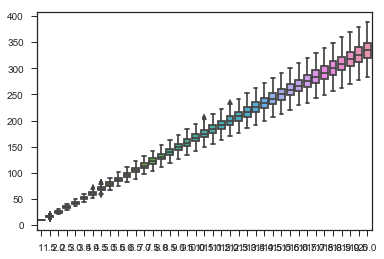

In [17]:
# for fun
sns.boxplot(data=df)

## KISS

If keeping 1 out of 2, why not keeping odd CP values only?

In [18]:
odd_count = 0
for cp in all_values:
    if cp%2==1:
        odd_count += 1
odd_count, len(all_values), str(int(odd_count/len(all_values)*100))+'%'

(190061, 390000, '48%')

Yep, it would work ! But it's less glorious ;-)